In [15]:
from sympy import *
from collections import defaultdict
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
init_printing()

### Bspline basis

In [60]:
xs = Symbol('x')
knots = [0,1,2,3,4,5,6]

# Third-order bspline
sym_basis = bspline_basis_set(3, knots, xs)
# Form for one basis function
sym_basis[0]

⎧           3                             
⎪          x                              
⎪          ──            for x ≥ 0 ∧ x < 1
⎪          6                              
⎪                                         
⎪   3                                     
⎪  x       2         2                    
⎪- ── + 2⋅x  - 2⋅x + ─   for x ≥ 1 ∧ x < 2
⎪  2                 3                    
⎪                                         
⎨ 3                                       
⎪x       2          22                    
⎪── - 4⋅x  + 10⋅x - ──   for x ≥ 2 ∧ x < 3
⎪2                  3                     
⎪                                         
⎪   3                                     
⎪  x       2         32                   
⎪- ── + 2⋅x  - 8⋅x + ──  for x ≥ 3 ∧ x ≤ 4
⎪  6                 3                    
⎪                                         
⎩          0                 otherwise    

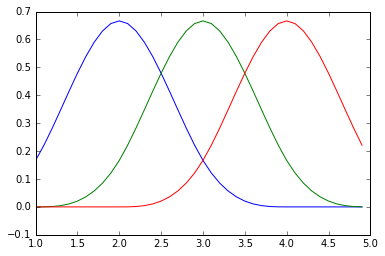

In [62]:
# Plot some basis functions
nbasis_to_plot = 3
npoints_to_plot = 40
basis_y = np.zeros((nbasis_to_plot, npoints_to_plot))
xvals = np.zeros(npoints_to_plot)
for i in range(npoints_to_plot):
    xv = i*.1 + 1.0
    for j in range(3):
        basis_y[j,i] = sym_basis[j].subs(xs,xv)
    xvals[i] = xv
plt.plot(xvals, basis_y[0,:], xvals, basis_y[1,:], xvals, basis_y[2,:])

### Function approximation
To fully represent an interval (say, 0.0 - 5.0, with a knot spacing of 1.0), we need parts of basis functions outside the interval as well.  To approximate a function, we evaluate at the M knots (there are 6 knots for this example).  There will be M+2 basis functions.

In [63]:
# Need knot values outside the target interval to generate the right set of basis functions.
knots = [0,1,2,3,4,5]
all_knots = [-3,-2,-1,0,1,2,3,4,5,6,7,8]

# Third-order bspline
sym_basis = bspline_basis_set(3, all_knots, xs)
print("Number of basis functions = ",len(sym_basis))
sym_basis

Number of basis functions =  8


⎡⎧  3      2                                  ⎧  3                            
⎢⎪ x    3⋅x    9⋅x   9                        ⎪ x     2         4             
⎢⎪ ── + ──── + ─── + ─   for x ≥ -3 ∧ x < -2  ⎪ ── + x  + 2⋅x + ─   for x ≥ -2
⎢⎪ 6     2      2    2                        ⎪ 6               3             
⎢⎪                                            ⎪                               
⎢⎪   3      2                                 ⎪      3                        
⎢⎪  x    5⋅x    7⋅x   5                       ⎪     x     2   2               
⎢⎪- ── - ──── - ─── - ─  for x ≥ -2 ∧ x < -1  ⎪   - ── - x  + ─     for x ≥ -1
⎢⎪  2     2      2    6                       ⎪     2         3               
⎢⎪                                            ⎪                               
⎢⎨    3    2                                , ⎨     3                         
⎢⎪   x    x    x   1                          ⎪    x     2   2                
⎢⎪   ── + ── - ─ + ─     for x ≥ -1 ∧ x < 0   ⎪    ─

To approximate a function we need coefficients for each basis function 
$$
f(x) = \sum_0^{M+2} c_i B_i(x)
$$
The values of the function at the knots provides $M$ constraints.  We still need 2 more to fully specify the coefficients.   This is where the boundary conditions come into play.

$$
\sum_0^{M+2} c_i B_i(x_j) = g(x_j)
$$

In [116]:
# Fill out the coefficient matrix
mat = Matrix.eye(len(knots)+2)
for i,k in enumerate(knots):
    for j,basis in enumerate(sym_basis):
        bv = basis.subs(xs,k)
        mat[i+1,j] = bv

# Natural boundary conditions - set 2nd derivative at end of range to zero
dd_spline = [diff(bs, xs, 2) for bs in sym_basis]

row0 = [dds.subs(xs, 0) for dds in dd_spline]
rowN = [dds.subs(xs, knots[-1]) for dds in dd_spline]
display(row0)
display(rowN)
for i in range(len(row0)):
    mat[0,i] = row0[i]
    mat[-1,i] = rowN[i]
mat


⎡ 1   -2    1    0    0    0    0    0 ⎤
⎢                                      ⎥
⎢1/6  2/3  1/6   0    0    0    0    0 ⎥
⎢                                      ⎥
⎢ 0   1/6  2/3  1/6   0    0    0    0 ⎥
⎢                                      ⎥
⎢ 0    0   1/6  2/3  1/6   0    0    0 ⎥
⎢                                      ⎥
⎢ 0    0    0   1/6  2/3  1/6   0    0 ⎥
⎢                                      ⎥
⎢ 0    0    0    0   1/6  2/3  1/6   0 ⎥
⎢                                      ⎥
⎢ 0    0    0    0    0   1/6  2/3  1/6⎥
⎢                                      ⎥
⎣ 0    0    0    0    0    1   -2    1 ⎦

In [109]:
# Let us assume a simple quadratic function for interpolation
func_to_approx = [k*k for k in knots]
func_to_approx

### Solve for coefficients

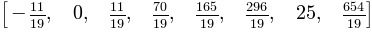

In [115]:
lhs_vals = [0] + func_to_approx + [0]  # Zeros are the value of the second derivative
coeffs = mat.LUsolve(Matrix(len(lhs_vals), 1, lhs_vals))
coeffs.T.tolist()[0]

### Evaluate the spline

In [85]:
def spline_eval(basis, coeffs, x):
    val = 0.0
    for c,bs in zip(coeffs, basis):
        val += c*bs.subs(xs,x)
    return val

In [111]:
# check that it reproduces the knots
for k,v in zip(knots,func_to_approx):
    print(k,spline_eval(sym_basis, coeffs, k),v)

0 0 0
1 1 1
2 4 4
3 9 9
4 16 16
5 25 25


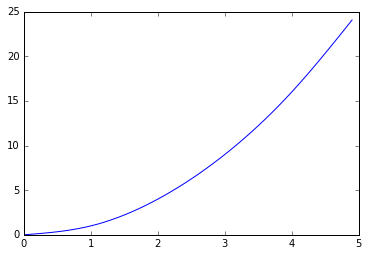

In [112]:
# Now check elsewhere
xvals = []
yvals = []
for i in range(50):
    x = .1*i
    val = spline_eval(sym_basis, coeffs, x)
    xvals.append(x)
    yvals.append(val)
plt.plot(xvals, yvals)
#plt.plot(xvals, yvals, knots, func_to_approx)

### Matching Einspline
The einspline code collects the values of each power of x in each interval.  The current form of the basis functions is a piecewise interval on the inside, and multiplication by the coefficients on the outside.  We would like to transpose this representation so that the intervals are on the outside, and the constributions from each coefficient are on the inside.  This will require some examination of the Sympy representation for intervals.

In [117]:
def to_interval(ival):
    """Convert relational expression to an Interval"""
    min_val = None
    lower_open = False
    max_val = None
    upper_open = True
    if isinstance(ival, And):
        for rel in ival.args:
            #print('rel ',rel, type(rel), rel.args[1])
            if isinstance(rel, StrictGreaterThan):
                min_val = rel.args[1]
                #lower_open = True
            elif isinstance(rel, GreaterThan):
                min_val = rel.args[1]
                #lower_open = False
            elif isinstance(rel, StrictLessThan):
                max_val = rel.args[1]
                #upper_open = True
            elif isinstance(rel, LessThan):
                max_val = rel.args[1]
                #upper_open = False
            else:
                print('unhandled ',rel)

    if min_val == None or max_val == None:
        print('error',ival)
    return Interval(min_val, max_val, lower_open, upper_open)

Interval =  [0, 1)


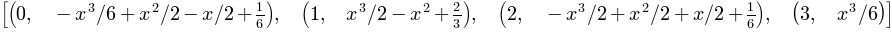

Interval =  [5, 6)


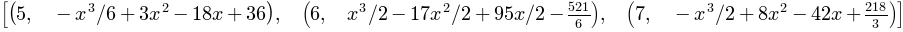

Interval =  [3, 4)


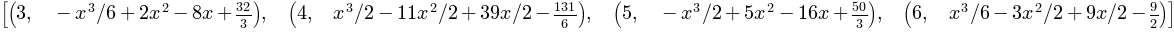

Interval =  [2, 3)


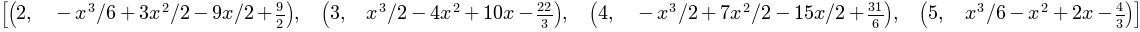

Interval =  [1, 2)


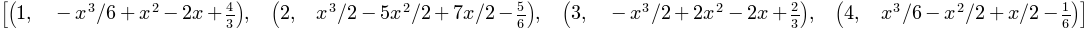

Interval =  [4, 5)


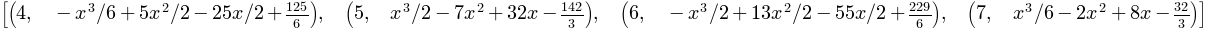

In [128]:
# Transpose the interval and coefficients
#  Note that interval [0,1) has the polynomial coefficients found in the einspline code
#  The other intervals could be shifted, and they would also have the same polynomials
cond_map = defaultdict(list)

i1 = Interval(0,5, False, False) # interval for evaluation
for idx, s0 in enumerate(sym_basis):
    for expr, cond in s0.args:
        if cond != True:
            i2 = to_interval(cond)
            if not i1.is_disjoint(i2):
                cond_map[i2].append( (idx, expr) )
for cond, expr in cond_map.items():
    #print(cond, [e.subs(x, x-cond.args[0]) for e in expr])
    print("Interval = ",cond)
    # Shift interval to a common start - see that the polynomial coefficients are all the same
    #e2 = [expand(e[1].subs(xs, xs+cond.args[0])) for e in expr]
    e2 = [(idx,expand(e)) for idx, e in expr]
    display(e2)

In [129]:
# Create piecewise expression from the transposed intervals
def recreate_piecewise(basis_map, c):
    args = []
    for cond, exprs in basis_map.items():
        e = 0
        for idx, b in exprs:
            e += c[idx] * b
        args.append( (e, cond.as_relational(xs)))
    return Piecewise(*args)

c = IndexedBase('c')
spline = recreate_piecewise(cond_map, c)
spline

⎧                        3        ⎛ 3         ⎞        ⎛   3    2        ⎞    
⎪                       x ⋅c[3]   ⎜x     2   2⎟        ⎜  x    x    x   1⎟    
⎪                       ─────── + ⎜── - x  + ─⎟⋅c[1] + ⎜- ── + ── + ─ + ─⎟⋅c[2
⎪                          6      ⎝2         3⎠        ⎝  2    2    2   6⎠    
⎪                                                                             
⎪               ⎛   3                    ⎞        ⎛   3                   ⎞   
⎪               ⎜  x       2          218⎟        ⎜  x       2            ⎟   
⎪               ⎜- ── + 8⋅x  - 42⋅x + ───⎟⋅c[7] + ⎜- ── + 3⋅x  - 18⋅x + 36⎟⋅c[
⎪               ⎝  2                   3 ⎠        ⎝  6                    ⎠   
⎪                                                                             
⎪  ⎛   3                   ⎞        ⎛   3                  ⎞        ⎛ 3      2
⎪  ⎜  x       2          50⎟        ⎜  x       2         32⎟        ⎜x    3⋅x 
⎪  ⎜- ── + 5⋅x  - 16⋅x + ──⎟⋅c[5] + ⎜- ── + 2⋅x  - 8

In [134]:
def spline_eval2(spline, coeffs, x):
    """Evaluate spline using transposed expression"""
    val = 0.0
    c = IndexedBase('c')
    to_sub = {}
    for i,cf in enumerate(coeffs):
        to_sub[c[i]] = cf
    to_sub[xs] = x
    return spline.subs(to_sub)


In [135]:
for k in knots:
    val = spline_eval2(spline, coeffs, k)
    print(k,val)

0 0
1 1
2 4
3 9
4 16
5 25
